In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! cp '/content/drive/My Drive/tweet-sentiment-extraction/preprocessed_train.csv' .
! cp '/content/drive/My Drive/tweet-sentiment-extraction/preprocessed_test.csv' .

In [ ]:
train_df = pd.read_csv('preprocessed_train.csv')
test_df = pd.read_csv('preprocessed_test.csv')

In [ ]:
train_df.shape,test_df.shape

((27469, 5), (3534, 3))

In [ ]:
train_df.head()

,textID,text,selected_text,sentiment,misspelled
0,cb774db0d1,i`d have responded if i were going,i`d have responded if i were going,neutral,No
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,No
2,088c60f138,my boss is bullying me,bullying me,negative,No
3,9642c003ef,what interview leave me alone,leave me alone,negative,No
4,358bd9e861,sons of curse why couldn`t they put them on th...,sons of curse,negative,No


In [ ]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,last session of the day links,neutral
1,96d74cb729,shanghai is also really exciting precisely sky...,positive
2,eee518ae67,recession hit veronique branquinho she has to ...,negative
3,01082688c6,happy bday,positive
4,33987a8ee5,links i like it,positive


In [ ]:
def find_start_indices(x):
    text,sel_text  = x[0],x[1]
    text = text.split()
    sel_text = sel_text.split()
    end = sel_text[0]
    index = text.index(end)
    return index

In [ ]:
train_df['start_indices'] = train_df[['text','selected_text']].progress_apply(lambda x:find_start_indices(x),axis=1)

In [ ]:
def find_end_indices(x):
    text,sel_text,start_indices  = x[0],x[1],x[2]
    text = text.split()
    sel_text = sel_text.split()
    end = sel_text[-1]
    try:
        index = text.index(end,start_indices)
    except:
        index = text.index(end)
        
    return index

In [ ]:
train_df['end_indices'] = train_df[['text','selected_text','start_indices']].progress_apply(lambda x:find_end_indices(x),axis=1)

In [ ]:
train_df[train_df.end_indices<train_df.start_indices ].shape

(23, 7)

We have 23 rows where the start indices are greater than end incides. we can drop these rows

In [ ]:
train_df = train_df[train_df.end_indices>=train_df.start_indices ]

In [ ]:
train_df.shape

(27446, 7)

In [ ]:
train_df.sample(15)

,textID,text,selected_text,sentiment,misspelled,start_indices,end_indices
2254,6774ef79d9,good morning driving to work,good morning,positive,No,0,1
3965,1f7ac5ca5e,so cold,so cold,negative,No,0,1
26048,2295b8227e,is highly amused i wasn`t treated nicely like ...,highly amused,positive,No,1,2
1308,47ffe3c006,finished proofing the wedding from march now j...,finished proofing the wedding from march now j...,neutral,No,0,22
3666,e0ca22d6d5,not really d nice pic no but could u imagine t...,nice,positive,No,3,3
25170,5963cc7a4e,i hope filming is going well i`m new to the wh...,i hope filming is going well i`m new to the wh...,neutral,No,0,19
3862,4b975e3f27,me are laying in the back of a fox truck on th...,me are laying in the back of a fox truck on th...,neutral,No,0,17
14733,e144ff3003,thanks i love the word crikey it`s like my sayin`,thanks,positive,No,0,0
14227,2006ca5e6a,ahh but sometimes that`s the best kind of day ...,ahh but sometimes that`s the best kind of day ...,neutral,No,0,16
26464,6fc59888b9,ahaha i have all of your albums each stuff of ...,ahaha i have all of your albums each stuff of ...,positive,No,0,23


In [ ]:
X = train_df[['text','sentiment']]
y = train_df[['start_indices','end_indices']]

In [ ]:
X.shape,y.shape

((27446, 2), (27446, 2))

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val= train_test_split(X,y,test_size=0.20,random_state=42)
x_train.shape,x_val.shape,y_train.shape,y_val.shape

((21956, 2), (5490, 2), (21956, 2), (5490, 2))

In [ ]:
train_text = x_train['text'].values
val_text = x_val['text'].values

In [ ]:
#import os
#os.listdir('/content/')


In [ ]:
import os
if  'glove.6B.300d.txt' not in os.listdir('/content/'):
  ! cp '/content/drive/My Drive/tweet-sentiment-extraction/glove.6B.300d.txt' .


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer_text = Tokenizer(lower=True,split=' ',oov_token='oov')
tokenizer_text.fit_on_texts(train_text)
train_text=tokenizer_text.texts_to_sequences(train_text)
val_text=tokenizer_text.texts_to_sequences(val_text)
print(len(train_text),len(val_text))
vocab_size_text=len(tokenizer_text.word_index)+1
print(vocab_size_text)

21956 5490
20901


In [ ]:
max_length_text=40
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_text = pad_sequences(train_text,maxlen=max_length_text,padding='post')
val_text = pad_sequences(val_text,maxlen=max_length_text,padding='post')
print(train_text.shape,val_text.shape)

(21956, 40) (5490, 40)


In [ ]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
from numpy import asarray
from numpy import zeros
embeddings_index = dict()
with open('/content/glove.6B.300d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
embedding_matrix = zeros((vocab_size_text, 300))
for word, i in tokenizer_text.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(20901, 300)


In [ ]:
train_sentiment = x_train['sentiment'].values
val_sentiment = x_val['sentiment'].values

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer_sentiment = Tokenizer(lower=True,split=' ',oov_token='oov')
tokenizer_sentiment.fit_on_texts(train_sentiment)
train_sentiment=tokenizer_sentiment.texts_to_sequences(train_sentiment)
val_sentiment=tokenizer_sentiment.texts_to_sequences(val_sentiment)
print(len(train_sentiment),len(val_sentiment))
print(tokenizer_sentiment.word_index)
vocab_size_sentiment=len(tokenizer_sentiment.word_index)+1
print(vocab_size_sentiment)

21956 5490
{'oov': 1, 'neutral': 2, 'positive': 3, 'negative': 4}
5


In [ ]:
max_length_sentiment=1
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_sentiment = pad_sequences(train_sentiment,maxlen=max_length_sentiment,padding='post')
val_sentiment = pad_sequences(val_sentiment,maxlen=max_length_sentiment,padding='post')
print(train_sentiment.shape,val_sentiment.shape)

(21956, 1) (5490, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding,Dense,Dropout,Concatenate,Flatten,Input,GRU,BatchNormalization,Bidirectional,SpatialDropout1D,LSTM,LayerNormalization
from tensorflow.keras.regularizers import l2

In [ ]:
input1=Input(shape=(max_length_text,),name='input_text')
embed = Embedding(vocab_size_text,300,input_length=max_length_text,name='embedding',\
                      trainable=False,embeddings_initializer=tf.constant_initializer(embedding_matrix))(input1)
gru=GRU(32,name='GRU',return_sequences=True)(embed)
f1=Flatten()(gru)

In [ ]:
input2=Input(shape=(max_length_sentiment,),name='input_sentiment')
embed2=Embedding(vocab_size_sentiment,10,input_length=max_length_sentiment,name='embedding_sentiment')(input2)
f2=Flatten()(embed2)

In [ ]:
concat1=Concatenate(axis=1)([f1,f2])
dense1=Dense(16,activation='relu',kernel_regularizer=l2(0.0001))(concat1)
drop1 = Dropout(0.6)(dense1)
ln= LayerNormalization()(drop1)
dense2=Dense(8,activation='relu',kernel_regularizer=l2(0.0001))(ln)
output=Dense(2,name='output')(dense2)

In [ ]:
model=Model(inputs=[input1,input2],outputs=[output])

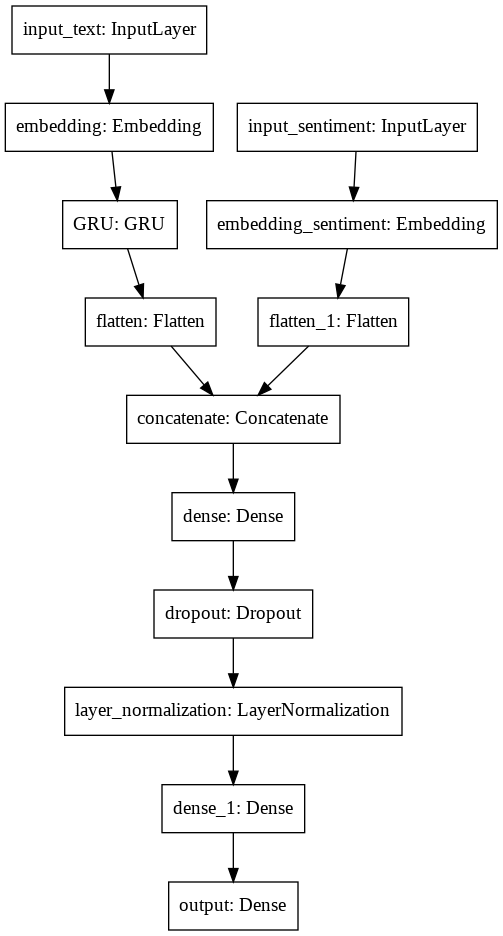

In [ ]:
import tensorflow
tensorflow.keras.utils.plot_model(model)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 300)      6270300     input_text[0][0]                 
__________________________________________________________________________________________________
input_sentiment (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
GRU (GRU)                       (None, 40, 32)       32064       embedding[0][0]                  
_______________________________________________________________________________________

In [ ]:
input_data = (train_text,train_sentiment)
output_data = y_train.values

val = (val_text,val_sentiment)
output_val = y_val.values
val_data = (val,output_val)

In [ ]:
%load_ext tensorboard
import datetime
import os
log_dir= os.path.join("tensorboard_logs1" , datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
! mkdir  'checkpt'
file_path = os.path.join('checkpt/model1.hdf5')
checkpt_save = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,save_weights_only=True,monitor='val_mae',save_best_only=True,verbose=1)
callbacks=[tensorboard_callback,checkpt_save]

In [ ]:
model.compile(optimizer='adam',loss="mse",metrics=["mae"])


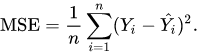

Mean Squared Error can be defined as the average squared difference between the actual and predicted values

In [ ]:
#how MSE works for Multi-output model
true_values = np.array([[1,2,3],[3,4.8,5],[6,6.0,8],[6.0,9,20]])
pred_values = np.array([[5,0,7],[5.0,0,5],[0,0,7],[5,0,8]])

mse = tensorflow.keras.losses.MeanSquaredError()
print(mse(true_values,pred_values))

tf.Tensor(30.170001983642578, shape=(), dtype=float64)


In [ ]:
print(np.square(true_values - pred_values))
f = ((np.square(true_values - pred_values)).flatten())
print(f)
print(np.sum(f))
print(np.sum(f) /len(f))
print(np.mean(np.square(true_values - pred_values)))

[[ 16.     4.    16.  ]
 [  4.    23.04   0.  ]
 [ 36.    36.     1.  ]
 [  1.    81.   144.  ]]
[ 16.     4.    16.     4.    23.04   0.    36.    36.     1.     1.
  81.   144.  ]
362.03999999999996
30.169999999999998
30.169999999999998


So MSE works as follows fr multi dim. data
 1. Calculate diff bt. true and pred values (true-pred)
 2. Square those values
 3. Calculate their mean values

In [ ]:
model.fit(input_data,output_data,epochs=100,batch_size=128,validation_data=val_data,validation_batch_size=64,callbacks=callbacks)

Epoch 1/100
  1/172 [..............................] - ETA: 0s - loss: 86.4400 - mae: 6.3488WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
171/172 [============================>.] - ETA: 0s - loss: 62.4024 - mae: 5.2268
Epoch 00001: val_mae improved from inf to 4.00235, saving model to checkpt/model1.hdf5
172/172 [==============================] - 4s 24ms/step - loss: 62.3218 - mae: 5.2223 - val_loss: 36.6754 - val_mae: 4.0024
Epoch 2/100
169/172 [============================>.] - ETA: 0s - loss: 35.0014 - mae: 3.9938
Epoch 00002: val_mae improved from 4.00235 to 3.55579, saving model to checkpt/model1.hdf5
172/172 [==============================] - 3s 19ms/step - loss: 34.9309 - mae: 3.9921 - val_loss: 23.7235 - val_mae: 3.5558
Epoch 3/100
170/172 [=========

In [ ]:
tf.keras.backend.clear_session()
%tensorboard --logdir $log_dir --port 0

**Compare MSE of this model with a random model**

In [ ]:
model.load_weights(file_path)

In [ ]:
pred_values = model.predict(input_data)
true_values = output_data

In [ ]:
mse = tensorflow.keras.losses.MeanSquaredError()
print(mse(true_values,pred_values))

tf.Tensor(11.400262, shape=(), dtype=float32)


In [ ]:
pred = np.mean(true_values,axis=0)
print(pred)

[2.7855256 8.6957096]


In [ ]:
pred = np.tile(pred,(true_values.shape[0],1))
print(pred)
print(pred.shape)

[[2.7855256 8.6957096]
 [2.7855256 8.6957096]
 [2.7855256 8.6957096]
 ...
 [2.7855256 8.6957096]
 [2.7855256 8.6957096]
 [2.7855256 8.6957096]]
(21956, 2)


In [ ]:
#MSE value for random model (mean value as start and end indices)
print(mse(true_values,pred))

tf.Tensor(34.11643981933594, shape=(), dtype=float64)


In [ ]:
print(train_df['start_indices'].value_counts()[:1])
print(train_df['end_indices'].value_counts()[:1])

0    16188
Name: start_indices, dtype: int64
3    2171
Name: end_indices, dtype: int64


In [ ]:
pred = [0,3]
pred = np.tile(pred,(true_values.shape[0],1))
print(pred)
print(pred.shape)

[[0 3]
 [0 3]
 [0 3]
 ...
 [0 3]
 [0 3]
 [0 3]]
(21956, 2)


In [ ]:
#MSE value for random model (most occurred value as start and end indicesss)
print(mse(true_values,pred))

tf.Tensor(53, shape=(), dtype=int64)


In [ ]:
test_df

,textID,text,sentiment
0,f87dea47db,last session of the day links,neutral
1,96d74cb729,shanghai is also really exciting precisely sky...,positive
2,eee518ae67,recession hit veronique branquinho she has to ...,negative
3,01082688c6,happy bday,positive
4,33987a8ee5,links i like it,positive
...,...,...,...
3529,e5f0e6ef4b,its at am im very tired but i can`t sleep but ...,negative
3530,416863ce47,all alone in this old house again thanks for t...,positive
3531,6332da480c,i know what you mean my little dog is sinking ...,negative
3532,df1baec676,sutra what is your next youtube video gonna be...,positive


In [ ]:
test_text = test_df['text'].values
test_text=tokenizer_text.texts_to_sequences(test_text)
test_text = pad_sequences(test_text,maxlen=max_length_text,padding='post')
test_text.shape

(3534, 40)

In [ ]:
test_sentiment = test_df['sentiment'].values
test_sentiment=tokenizer_sentiment.texts_to_sequences(test_sentiment)
test_sentiment = pad_sequences(test_sentiment,maxlen=max_length_sentiment,padding='post')
test_sentiment.shape

(3534, 1)

In [ ]:
results  = model.predict([test_text,test_sentiment])

In [ ]:
results.shape

(3534, 2)

In [ ]:
results = np.round(results)
results

array([[-0.,  4.],
       [ 3.,  4.],
       [ 5., 11.],
       ...,
       [ 5., 11.],
       [ 5., 11.],
       [ 1.,  5.]], dtype=float32)

In [ ]:
test_df['start'],test_df['end'] = (abs(results[:,0])),(abs(results[:,1]))

In [ ]:
test_df['start'] = test_df['start'].astype('int')
test_df['end'] = test_df['end'].astype('int')

In [ ]:
test_df

,textID,text,sentiment,start,end
0,f87dea47db,last session of the day links,neutral,0,4
1,96d74cb729,shanghai is also really exciting precisely sky...,positive,3,4
2,eee518ae67,recession hit veronique branquinho she has to ...,negative,5,11
3,01082688c6,happy bday,positive,1,4
4,33987a8ee5,links i like it,positive,1,5
...,...,...,...,...,...
3529,e5f0e6ef4b,its at am im very tired but i can`t sleep but ...,negative,2,5
3530,416863ce47,all alone in this old house again thanks for t...,positive,5,11
3531,6332da480c,i know what you mean my little dog is sinking ...,negative,5,11
3532,df1baec676,sutra what is your next youtube video gonna be...,positive,5,11


In [ ]:
def find_sel_text(x):
  txt , start , end = x[0],x[1],x[2]

  end=end+1
  txt = txt.split()
  sel_text = txt[start:end]
  sel_text = " ".join(sel_text)
  return sel_text

,textID,text,sentiment,start,end,selected_text
0,f87dea47db,last session of the day links,neutral,0,4,last session of the day
1,96d74cb729,shanghai is also really exciting precisely sky...,positive,3,4,really exciting
2,eee518ae67,recession hit veronique branquinho she has to ...,negative,5,11,has to quit her company such a
3,01082688c6,happy bday,positive,1,4,bday
4,33987a8ee5,links i like it,positive,1,5,i like it
...,...,...,...,...,...,...
3529,e5f0e6ef4b,its at am im very tired but i can`t sleep but ...,negative,2,5,am im very tired
3530,416863ce47,all alone in this old house again thanks for t...,positive,5,11,house again thanks for the net which
3531,6332da480c,i know what you mean my little dog is sinking ...,negative,5,11,my little dog is sinking into depression
3532,df1baec676,sutra what is your next youtube video gonna be...,positive,5,11,youtube video gonna be about i love
